In [ ]:
import sys
sys.path.append('./scripts')
import FinetuneNER

In [4]:
from transformers import Trainer , AutoTokenizer , TrainingArguments , DataCollatorForTokenClassification , DataCollatorWithPadding , AutoModelForTokenClassification
import pandas as pd
from datasets import Dataset 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import evaluate
import random

2025-06-24 15:22:36.815977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750778557.052596      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750778557.119942      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv(
    "/kaggle/input/amhar-ner/ner_auto_labels.conll",
    sep="\s+",
    names=["text", "label"],
    skip_blank_lines=False,
    engine="python"
)

# Replace empty lines with NaN to mark sentence boundaries
df["text"].replace("", pd.NA, inplace=True)

# Create sentence groups (each group = one sentence)
df["sentence_id"] = df["text"].isna().cumsum()

# Drop empty rows
df = df.dropna()

# Group by sentence
grouped = df.groupby("sentence_id").agg({
    "text": list,
    "label": list
}).reset_index(drop=True)


# Rename columns to match expected format
grouped.columns = ["tokens", "ner_tags"]

# Now your grouped DataFrame is ready for Dataset.from_pandas()

ner_dataset = Dataset.from_pandas(grouped)

print(ner_dataset[0])

{'tokens': ['በኤሌትሪክ', 'የሚሰራ', 'ምጣድ', 'ለፈጢራ', 'ለቂጣ', 'ለአምባሻና', 'ለተለያዩ', 'ነገሮች', 'መጋገሪያነት', 'የሚያገለግል', 'በተጨማሪም', 'ቡና', 'ለመቁላት', 'የሚመች', 'በአነስተኛ', 'የኤሌትሪክ', 'ሀይል', 'የሚሰራ', 'እጄታዉ', 'የማያቃጥል', 'ማቴሪያል', 'ሶኬቱ', 'ላይ', 'የሀይል', 'መቆጣጠሪያ', 'ፊዉዝ', 'የተገጠመለት', 'አድራሻ', 'መገናኛ', 'ስሪ', 'ኤም', 'ሲቲ', 'ሞል', 'ሁለተኛ', 'ፎቅ', 'ቢሮ', 'ቁ', 'ሊፍቱ', 'ፊት', 'ለ', 'ፊት', '0909522840', '0923350054', 'ለማዘዝ', 'ይጠቀሙ', 'ለተጨማሪ', 'ማብራሪያ', 'የቴሌግራም', 'ገፃችን'], 'ner_tags': ['B-PRODUCT', 'I-PRODUCT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


/tmp/ipykernel_35/2797670705.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["text"].replace("", pd.NA, inplace=True)


In [6]:
label_list = sorted(set(label for tags in ner_dataset["ner_tags"] for label in tags))
label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Encode ner_tags
ner_dataset = ner_dataset.map(
    lambda example: {"ner_tags": [label_to_id[label] for label in example["ner_tags"]]}
)

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [7]:
split_dataset = ner_dataset.train_test_split(test_size=0.1)

In [9]:
roberta_finetune = FinetuneNER("FacebookAI/xlm-roberta-base" , label_list)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
tokenized_dataset = split_dataset.map(roberta_finetune.tokenize_and_align_labels ,  batched=True)

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset.shape

{'train': (89, 5), 'test': (10, 5)}

In [12]:
colator = DataCollatorWithPadding(tokenized_dataset)

In [13]:
train_dataset , test_dataset = tokenized_dataset["train"] , tokenized_dataset["test"]
trained_roberta = roberta_finetune.train(train_dataset , test_dataset,5 , 8)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/795147254.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
12,1.415800
24,0.925200
36,0.764000
48,0.701800
60,0.642800


In [14]:
print(trained_roberta.evaluate())

{'eval_loss': 0.6809710264205933, 'eval_LOC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'eval_PRICE': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 5}, 'eval_PRODUCT': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 8}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.8129175946547884, 'eval_runtime': 3.3499, 'eval_samples_per_second': 2.985, 'eval_steps_per_second': 0.597, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from seqeval.metrics import classification_report as seqeval_report

def train_and_evaluate_with_confusion_matrix(trainer, label_list, use_seqeval=False):
    # Step 1: Train the model


    # Step 2: Get predictions
    predictions, labels, _ = trainer.predict(trainer.eval_dataset)
    preds = predictions.argmax(axis=-1)

    true_labels = []
    pred_labels = []

    for pred, label in zip(preds, labels):
        true_seq = []
        pred_seq = []
        for p, l in zip(pred, label):
            if l != -100:
                true_seq.append(label_list[l])
                pred_seq.append(label_list[p])
        true_labels.append(true_seq)
        pred_labels.append(pred_seq)

    if use_seqeval:
        # Step 3a: Entity-level evaluation with seqeval
        print("Classification Report (SeqEval):")
        print(seqeval_report(true_labels, pred_labels))

        # Step 4a: Flatten for confusion matrix (manually)
        true_flat = [label for seq in true_labels for label in seq]
        pred_flat = [label for seq in pred_labels for label in seq]
        labels_flat = sorted(list(set(true_flat + pred_flat)))

    else:
        # Step 3b: Token-level evaluation with sklearn
        true_flat = [label for seq in true_labels for label in seq]
        pred_flat = [label for seq in pred_labels for label in seq]
        labels_flat = label_list

        print("Classification Report (sklearn):")
        print(classification_report(true_flat, pred_flat, labels=labels_flat))

    # Step 5: Plot confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=labels_flat)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_flat, yticklabels=labels_flat, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("NER Confusion Matrix")
    plt.show()

    

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344

Classification Report (sklearn):
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
     B-PRICE       0.00      0.00      0.00         5
   B-PRODUCT       0.00      0.00      0.00         8
       I-LOC       0.76      0.25      0.38        51
     I-PRICE       0.00      0.00      0.00        15
   I-PRODUCT       0.00      0.00      0.00         8
           O       0.81      0.99      0.89       356

    accuracy                           0.81       449
   macro avg       0.23      0.18      0.18       449
weighted avg       0.73      0.81      0.75       449



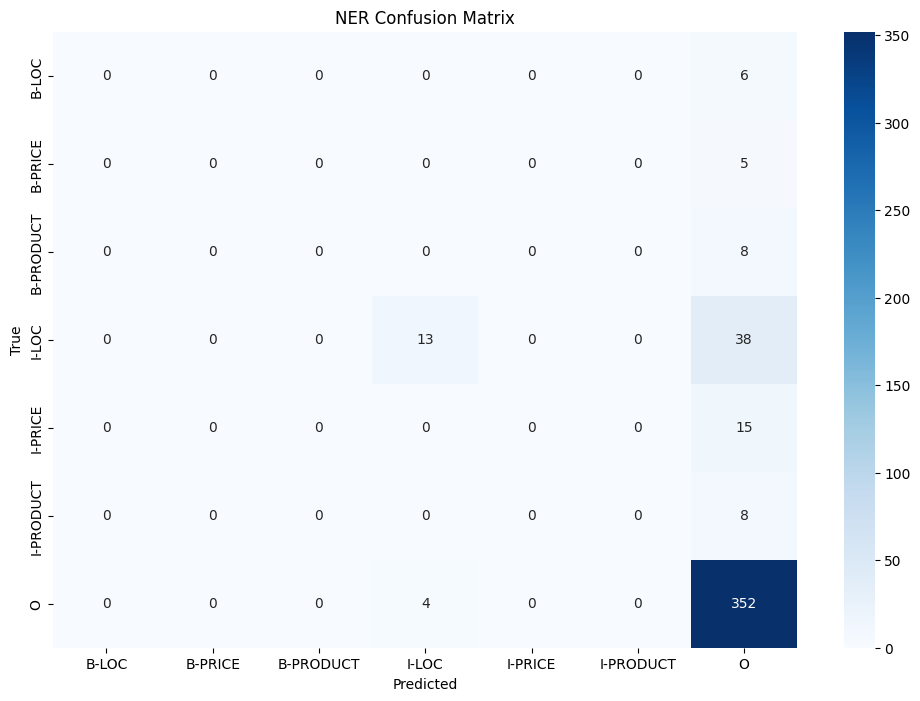

In [17]:
train_and_evaluate_with_confusion_matrix(trained_robert , label_list)